# Assignment parallel computing group 3

In [1]:
import fake_enformer 

In [2]:
fake_enformer.predict('hg38:chr4:8848348:A:T')

-0.0007830759576305497

In [3]:
#!cat /lustre1/project/stg_00079/teaching/data/snps.annotated.vcf

## Import libraries

In [2]:
import vcfpy
import pandas as pd
from multiprocessing import Pool
import multiprocessing
import cProfile
import time
import fake_enformer 

## Configuration

In [5]:
genome = "hg38"
vcf_path = '/lustre1/project/stg_00079/teaching/data/snps.annotated.vcf'

In [6]:
reader = vcfpy.Reader.from_path(vcf_path)

### Generate all variant strings

In [7]:
variant_strings = []

for i, record in enumerate(reader):
    assert len(record.ALT) == 1
    chrom = record.CHROM
    pos = record.POS
    ref = record.REF
    alt = record.ALT[0].value

    variant_str = f"{genome}:{chrom}:{pos}:{ref}:{alt}"
    variant_strings.append(variant_str)

In [6]:
#variant_strings

## Multiprocessing

In [13]:
with Pool(15) as pool:
    tic = time.perf_counter()
    results = pool.map(fake_enformer.predict, variant_strings[:50])
    toc = time.perf_counter()

# Process results as needed
print(f"Processed {len(results)} variants")
print(f"{toc - tic:0.4f} seconds")

Processed 50 variants
49.0045 seconds


In [21]:
import time
from multiprocessing import Pool
import matplotlib.pyplot as plt

# Desired pool sizes: 1, 5, 10, ..., 40
pool_sizes = [1, 2] + list(range(5, 45, 5))
timings = []

for size in pool_sizes:
    with Pool(size) as pool:
        tic = time.perf_counter()
        results = pool.map(fake_enformer.predict, variant_strings[:50])
        toc = time.perf_counter()
        timings.append(toc - tic)
        print(f"Pool size: {size} -> Time: {toc - tic:.4f} seconds")

Pool size: 1 -> Time: 588.0101 seconds
Pool size: 2 -> Time: 315.0066 seconds
Pool size: 5 -> Time: 130.0041 seconds
Pool size: 10 -> Time: 76.0037 seconds
Pool size: 15 -> Time: 49.0048 seconds
Pool size: 20 -> Time: 40.0030 seconds
Pool size: 25 -> Time: 35.0040 seconds
Pool size: 30 -> Time: 31.0065 seconds
Pool size: 35 -> Time: 29.0048 seconds
Pool size: 40 -> Time: 24.0065 seconds


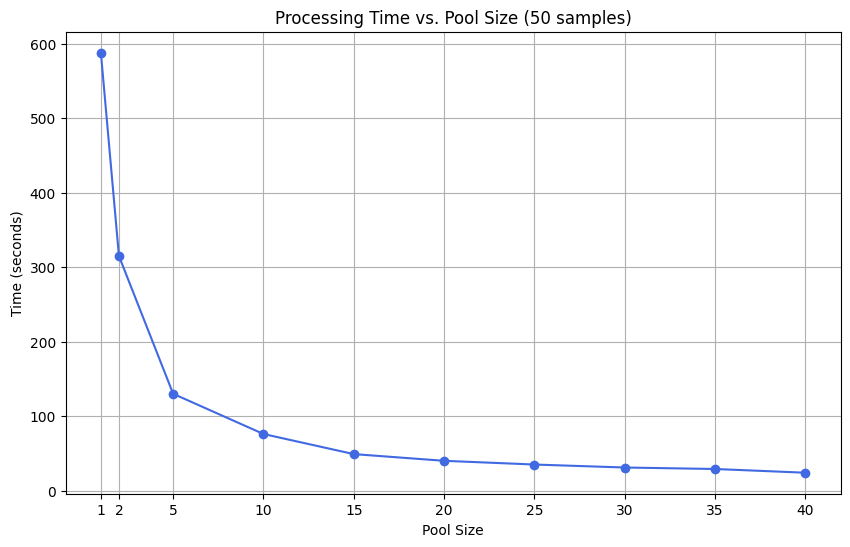

In [22]:
# Plotting
plt.figure(figsize=(10, 6))
plt.plot(pool_sizes, timings, marker='o', linestyle='-', color='royalblue')
plt.title("Processing Time vs. Pool Size (50 samples)")
plt.xlabel("Pool Size")
plt.ylabel("Time (seconds)")
plt.grid(True)
plt.xticks(pool_sizes)
plt.show()

In [23]:
import time
from multiprocessing import Pool
import matplotlib.pyplot as plt

# Desired pool sizes: 1, 5, 10, ..., 40
pool_sizes = [1] + list(range(5, 45, 5))
timings = []

for size in pool_sizes:
    with Pool(size) as pool:
        tic = time.perf_counter()
        results = pool.map(fake_enformer.predict, variant_strings[:500])
        toc = time.perf_counter()
        timings.append(toc - tic)
        print(f"Pool size: {size} -> Time: {toc - tic:.4f} seconds")

Pool size: 1 -> Time: 6444.7588 seconds
Pool size: 5 -> Time: 1352.2961 seconds
Pool size: 10 -> Time: 703.0128 seconds
Pool size: 15 -> Time: 485.0097 seconds
Pool size: 20 -> Time: 375.0078 seconds
Pool size: 25 -> Time: 294.0164 seconds
Pool size: 30 -> Time: 258.0089 seconds
Pool size: 35 -> Time: 224.0083 seconds
Pool size: 40 -> Time: 198.0074 seconds


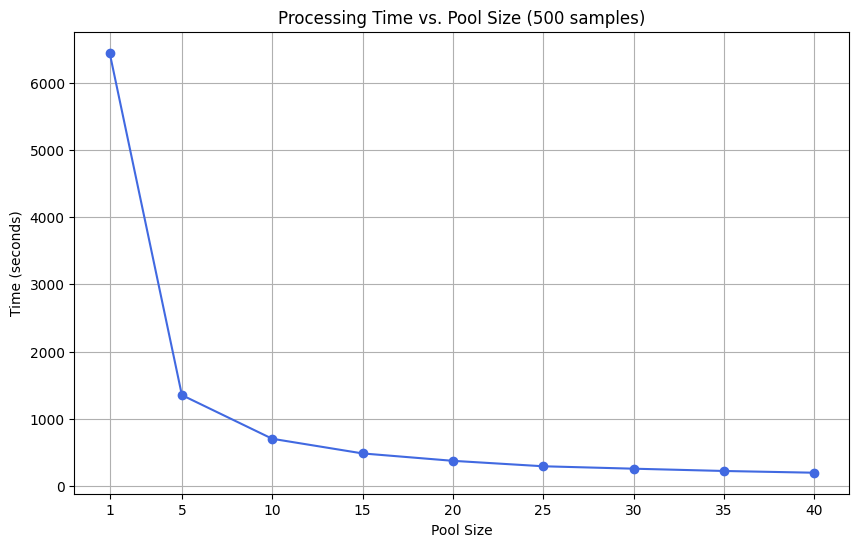

In [24]:
# Plotting
plt.figure(figsize=(10, 6))
plt.plot(pool_sizes, timings, marker='o', linestyle='-', color='royalblue')
plt.title("Processing Time vs. Pool Size (500 samples)")
plt.xlabel("Pool Size")
plt.ylabel("Time (seconds)")
plt.grid(True)
plt.xticks(pool_sizes)
plt.show()

In [20]:
list(results)

[0.00044179413988254404]

### Entire dataset

In [10]:
with Pool(40) as pool:
    tic = time.perf_counter()
    results = pool.map(fake_enformer.predict, variant_strings)
    toc = time.perf_counter()

# Process results as needed
print(f"Processed {len(results)} variants")
print(f"{toc - tic:0.4f} seconds")

Processed 3499 variants
1218.0242 seconds


## Save to new VCF

In [11]:
# Update header with new FORMAT field
new_header = reader.header.copy()
new_header.add_info_line({
    'ID': 'EF',
    'Number': '1',
    'Type': 'Float',
    'Description': 'Enformer prediction score'
})

True

In [12]:
writer = vcfpy.Writer.from_path("snps_annotated_new.vcf", new_header)
reader = vcfpy.Reader.from_path(vcf_path)
for i, record in enumerate(reader):
    if list(results)[i] is not None:
        # Add prediction to INFO field
        record.INFO['EF'] = results[i]
    writer.write_record(record)

print(f"Successfully wrote {len(results)} variants")

Successfully wrote 3499 variants


In [ ]:
!cat snps_annotated_new.vcf